In [1]:
%%html
<! –– HTML style sheet addition to hide input field -->

<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

In [2]:
def hide_code_in_slideshow():
    # Function to hide input field when in slideshow mode
    from IPython import display
    import binascii
    import os
    uid = binascii.hexlify(os.urandom(8)).decode()    
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;
            while (!p.hasClass("cell")) {
                p=p.parent();
                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

<img align="right" width="200" height="200" src="tornado3d_lines.png">

# GPU-Based Vector Field Visualizations using 3D Textures

## Eric Hackathorn 5/21/2020
<Eric.J.Hackathorn@noaa.gov>

<em>Enter slide show mode using the "RISE" button in the toolbar or Alt-R</em>


# Today's Highlights
- Using Jupyter as a presentation tool running in a cloud-based docker container
- Extract useful volumetric data from popular scientific formats
- Deploying Flask microservice for communication
- Investigate new visualization techniques for GPU-based visualization

## Inspiration from the Game Industry
- Could the special effects seen in the movie be applied to scientific visualizations?

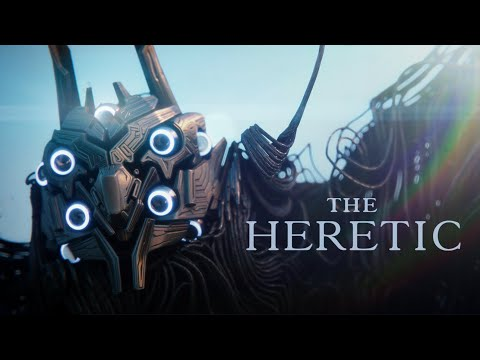

In [3]:
hide_code_in_slideshow()
from IPython.display import Audio,Image, YouTubeVideo
id='iQZobAhgayA'
YouTubeVideo(id=id,width=960,height=540,start=115)

## Links to Assets
- Movie assets are available under an open license
  - [Visual Effect Samples](https://github.com/Unity-Technologies/VisualEffectGraph-Samples)
  - [Digital Human Demonstration](https://github.com/Unity-Technologies/com.unity.demoteam.digital-human.sample)

## Volumetric Windflow Visualization of a Tornado
- Visualization rendered in real-time using Unity


In [4]:
hide_code_in_slideshow()
from IPython.display import Audio,Image, VimeoVideo
id='419597137'
VimeoVideo(id=id,width=960,height=540)

### Background
- A [synthetic model of a tornado](http://web.cse.ohio-state.edu/~crawfis.3/Data/Tornado/tornadoSrc.c) created by Roger Crawfis 
- Output saved as [NetCDF](https://cgl.ethz.ch/research/visualization/data.php)

## Back to the Basics

### Read the NetCDF Dataset as Xarray object

- Import required modules and packages
- Open the tornado dataset to explore groups, dimensions, variables

In [5]:
import numpy as np
import pandas as pd
import xarray as xr

data_path = "data/"
data_file = "tornado3d.nc"


In [6]:
# data_path and data_file were defined in the previous cell. These could point at the Flask server.

ds = xr.open_dataset(data_path + data_file)
ds.load()

<xarray.Dataset>
Dimensions:  (xdim: 128, ydim: 128, zdim: 128)
Coordinates:
  * xdim     (xdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * ydim     (ydim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
  * zdim     (zdim) float32 -10.0 -9.84252 -9.6850395 ... 9.6850395 9.84252 10.0
Data variables:
    u        (zdim, ydim, xdim) float32 -0.12064955 -0.07151286 ... 1.7160951
    v        (zdim, ydim, xdim) float32 -1.9327921 -1.9486377 ... 0.6359221
    w        (zdim, ydim, xdim) float32 -0.014655841 -0.015212318 ... 0.0 0.0
Attributes:
    creation_date:  16-Apr-2019 17:36:10
    grid:           regular

## Reshape variables
- Have 3 variables (u,v,w) each with shape = (128,128,128)
- Need one array of shape (128,128,128,3) to create a 3D texture
- Combine three variable into one using np.stack

In [7]:
# ds is the previously defined xarray data set

u = ds.u.values
v = ds.v.values
w = ds.w.values

In [8]:
# combine variables with np.stack making the new dimension the last

uvw = np.stack((u, v, w), axis=-1)
print('uvw shape = ', uvw.shape)
print('total cells are ', np.prod(uvw.shape))   # uvw.shape

uvw shape =  (128, 128, 128, 3)
total cells are  6291456


## Find min-max of u-v-w velocities
- The metadata from the tornado NetCDF states these values are unitless

In [9]:
uvw_min = np.amin(uvw)
print("min value = " + str(uvw_min))
uvw_max = np.amax(uvw)
print("max value = " + str(uvw_max))

min value = -6.2111263
max value = 6.2132716


## Normalize and Scale for RGB color
- Values between 0 and 255 for each wind component
- U = R, V = G, W = B

In [10]:
uvw_norm = (255 * (uvw / (uvw_max-uvw_min) - (uvw_min/(uvw_max-uvw_min)))).astype(np.int)
uvw_norm[:2,:2,:2,:]

array([[[[125,  87, 127],
         [126,  87, 127]],

        [[125,  87, 127],
         [126,  87, 127]]],


       [[[123,  88, 127],
         [124,  87, 127]],

        [[124,  87, 127],
         [125,  87, 127]]]])

## Plot Distributions of UVW
- Understand what's in this dataset
- Sanity check for final visualizations

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Since > 6M cells, random sample for efficiency
uvw_sample = np.random.choice(np.ndarray.flatten(uvw_norm), 10**4)
uvw_sampleU = np.random.choice(np.ndarray.flatten(uvw_norm[:,:,:,0]), 10**4)
uvw_sampleV = np.random.choice(np.ndarray.flatten(uvw_norm[:,:,:,1]), 10**4)
uvw_sampleW = np.random.choice(np.ndarray.flatten(uvw_norm[:,:,:,2]), 10**4)

## Plot Distribution of Sample UVW Values After Normalization
- Values are centered around 127 which represents zero velocity

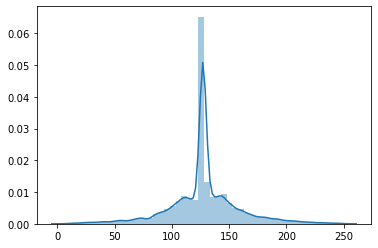

In [12]:
sns.distplot(uvw_sample)

## Plot Distribution of Sample UV Values After Normalization
- Values show a fairly even distributon of horizontal wind components 

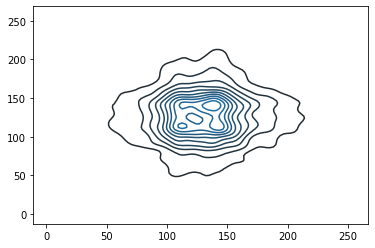

In [13]:
sns.kdeplot(uvw_sampleU, uvw_sampleV)

## Plot Distribution of Sample W Values After Normalization
- Values show relatively minimal updraft
- Do things get tossed around in tornados more than they are sucked into the air?

D:\ProgramData\Anaconda3\envs\texture3d\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


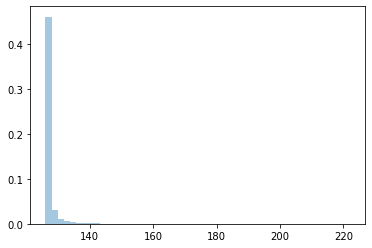

In [14]:
sns.distplot(uvw_sampleW)

## Plot array slices for animation
- In the first three plots blue color indictes negative component values, red positive
- The forth plot shows the RGB values (representing the Vector3) for each vertical slice
<img align="center" src="images/RGB_Slice0000.png">

In [15]:
from PIL import Image

<ipython-input-16-ac370d995caf>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,5))


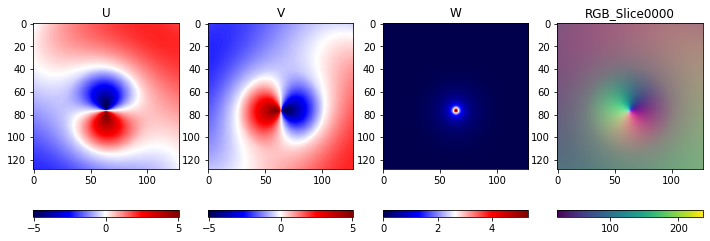

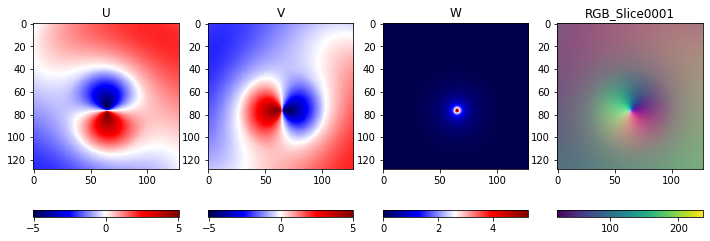

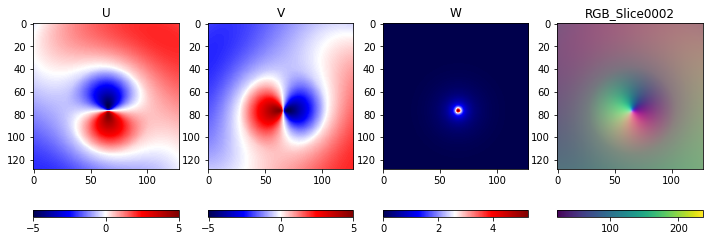

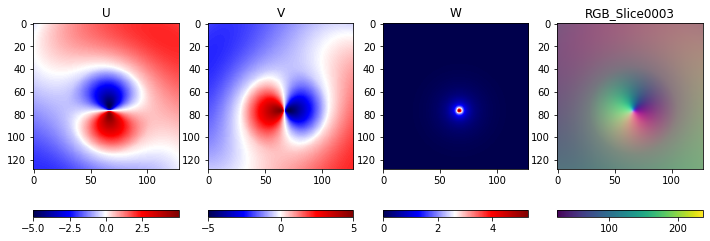

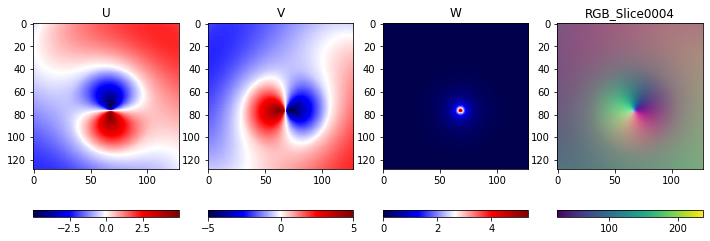

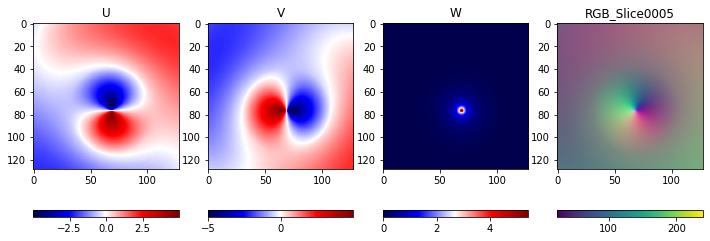

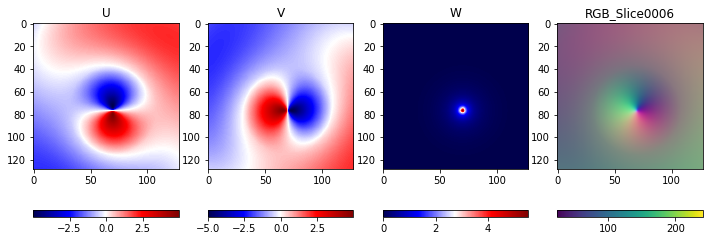

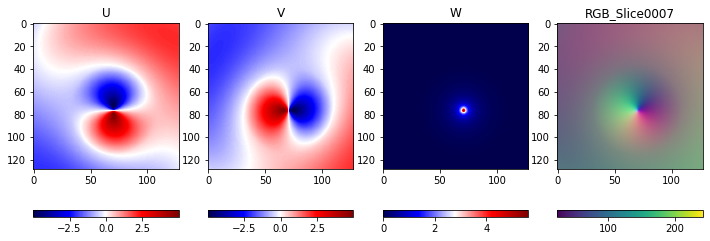

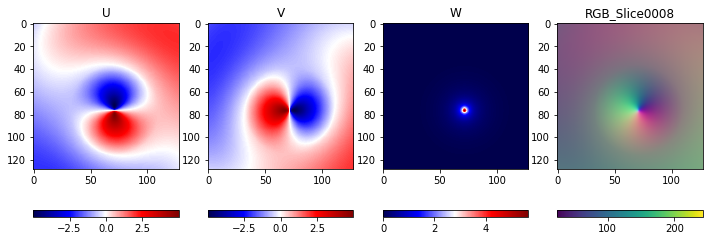

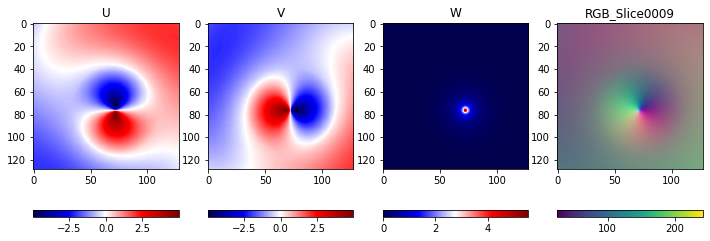

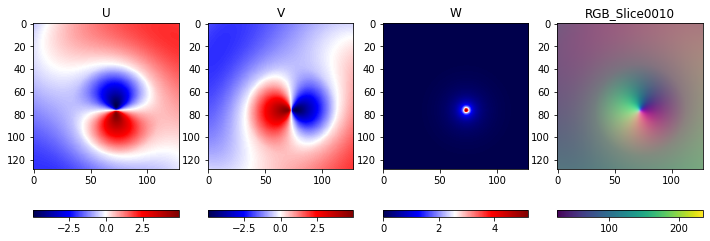

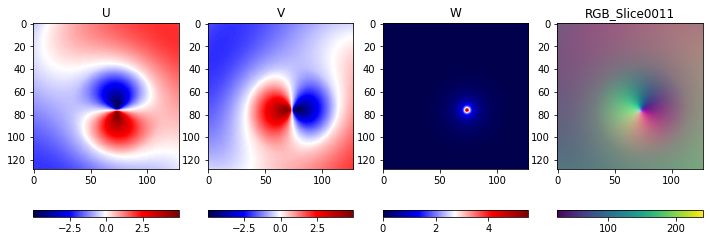

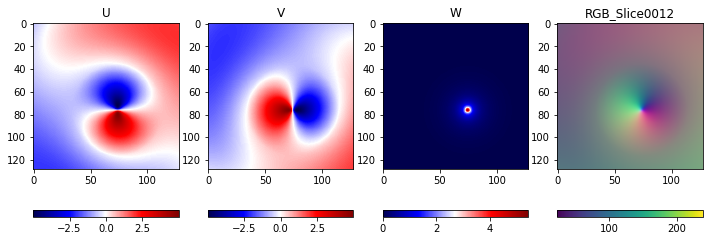

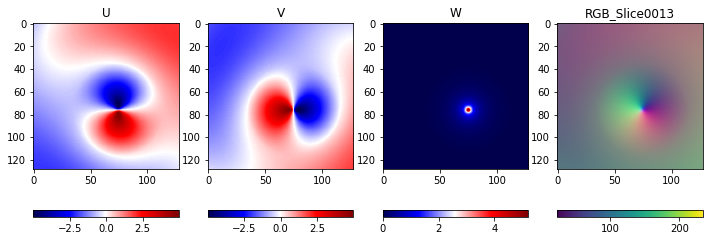

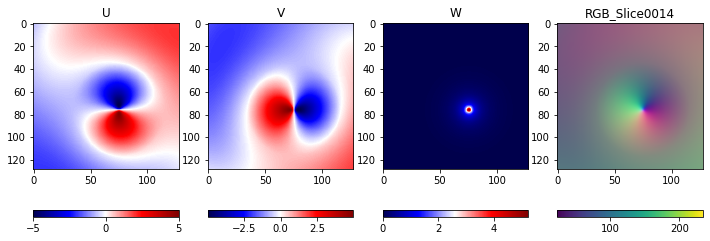

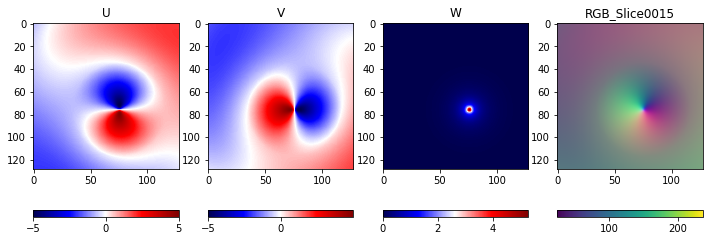

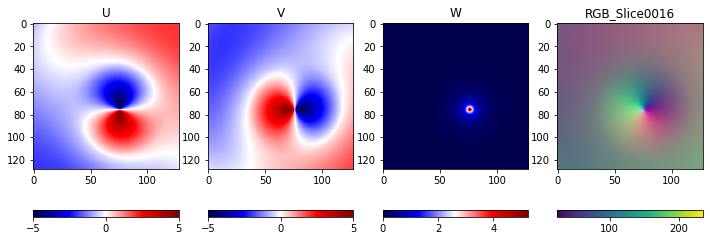

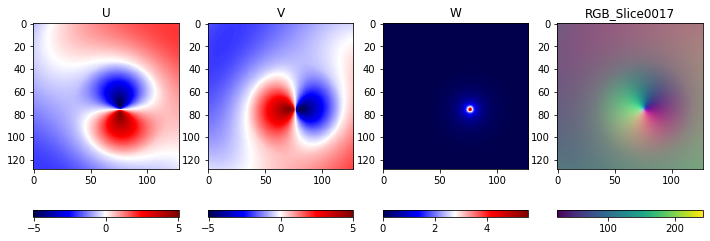

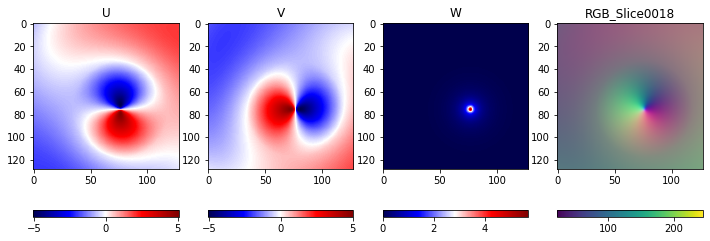

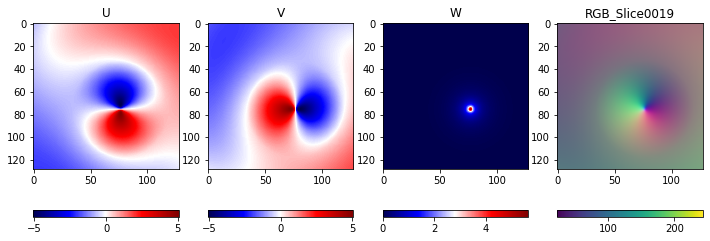

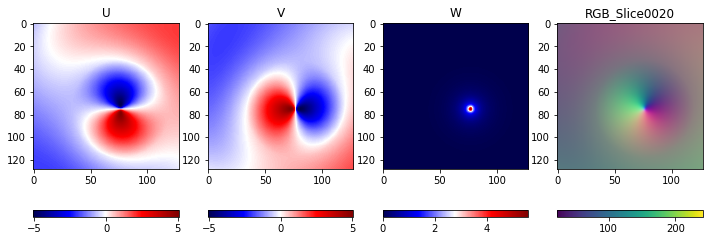

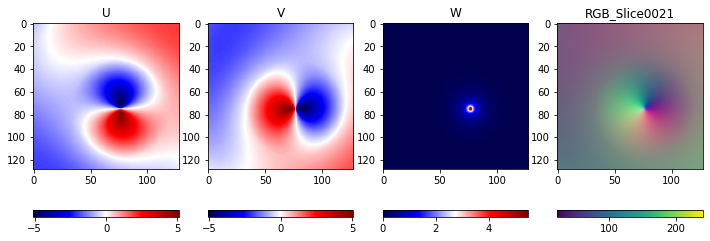

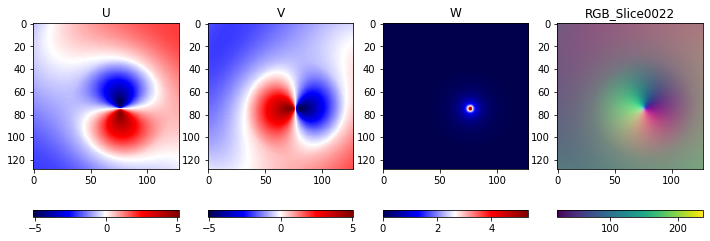

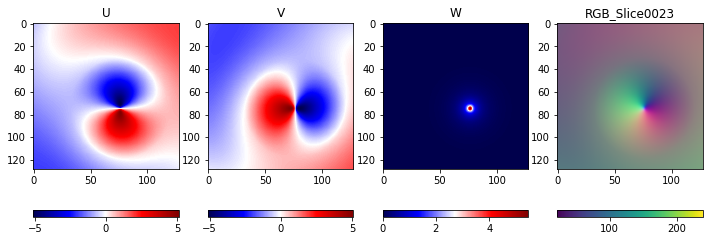

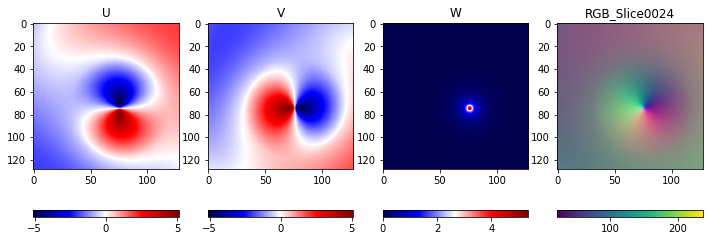

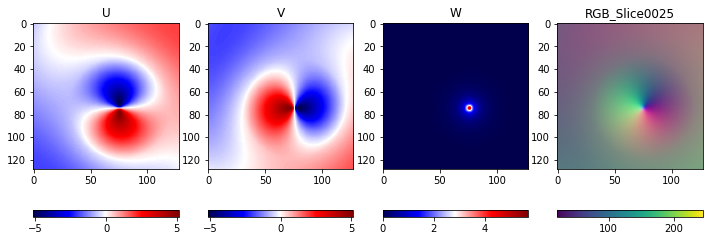

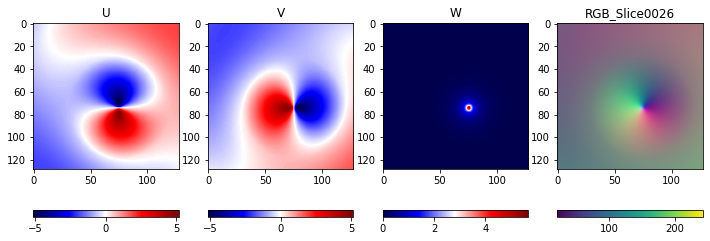

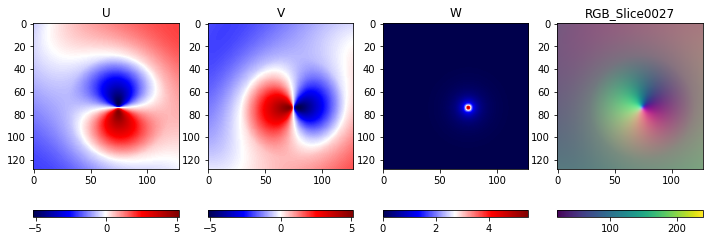

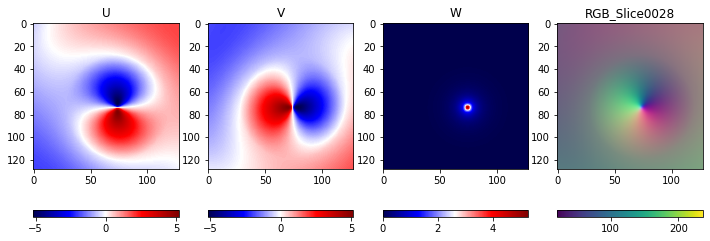

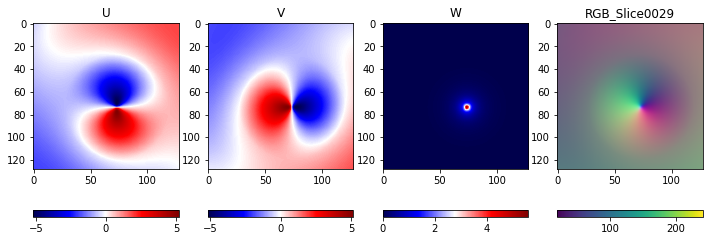

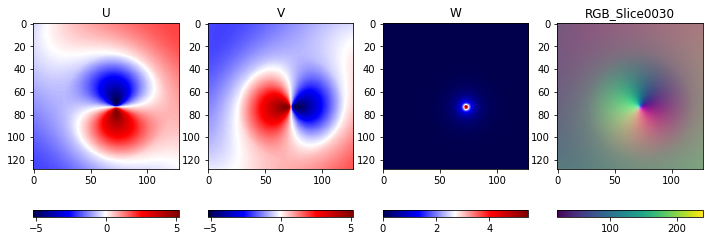

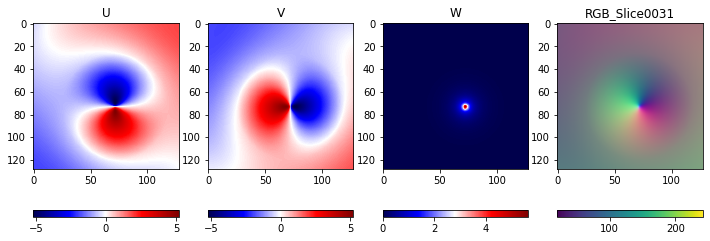

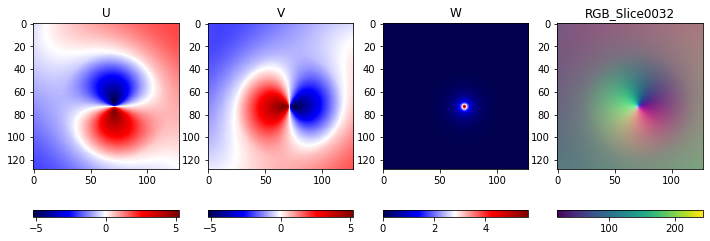

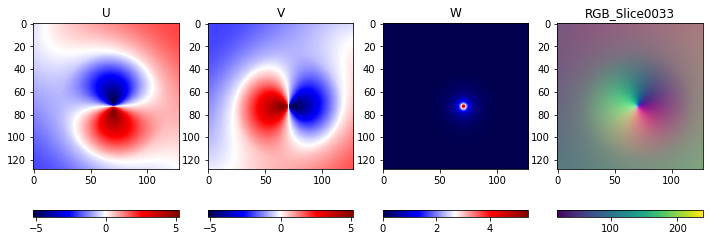

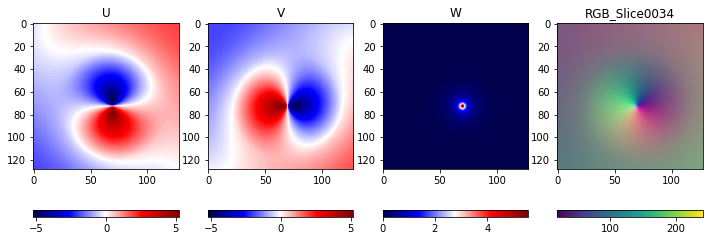

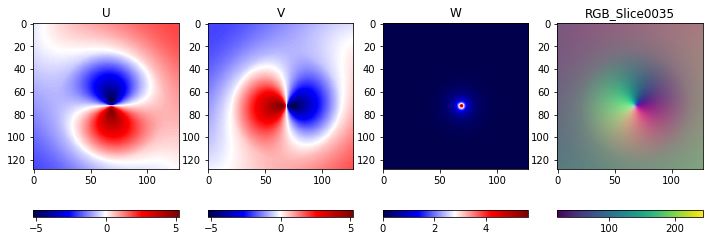

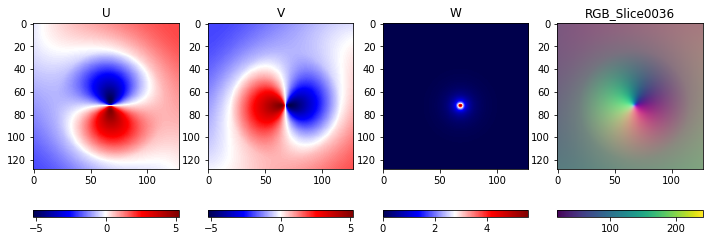

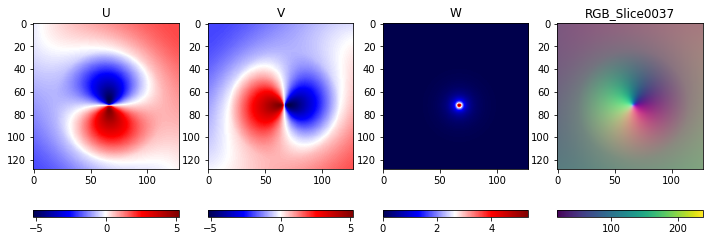

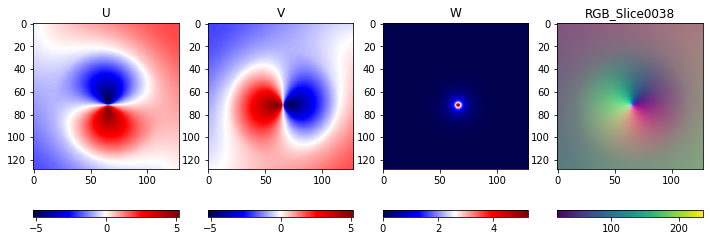

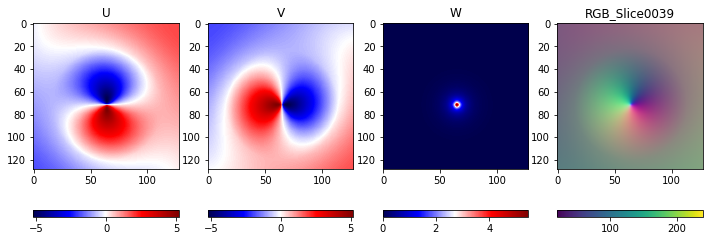

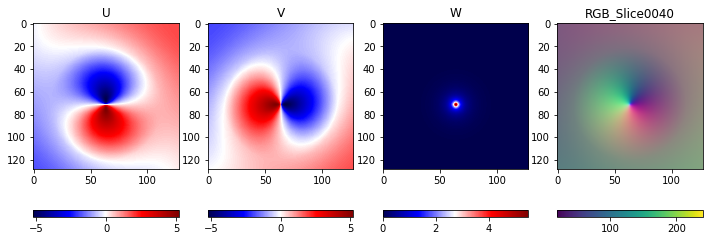

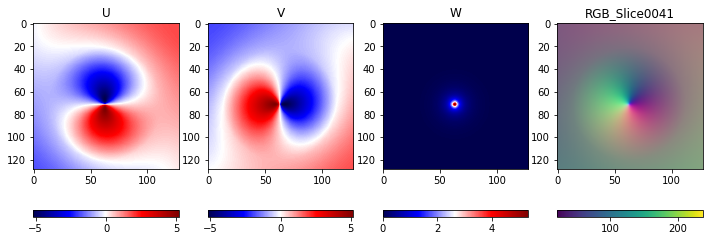

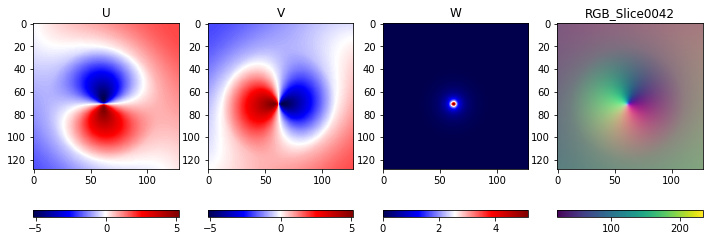

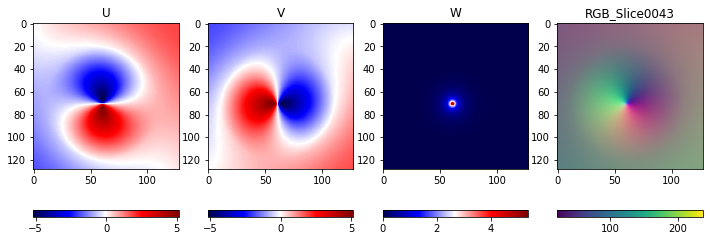

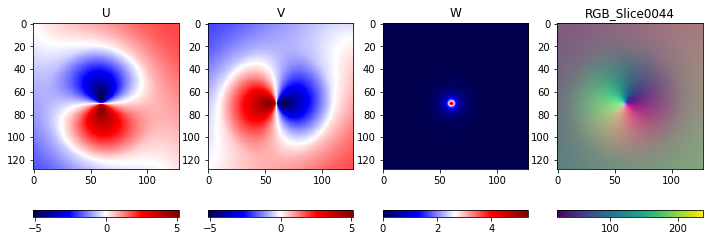

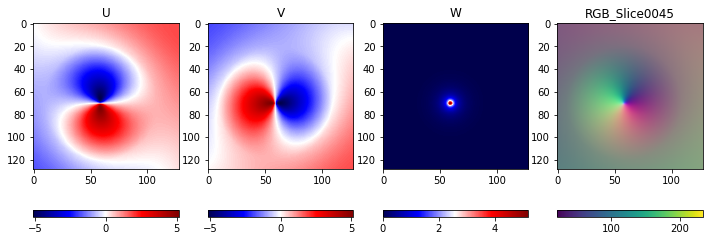

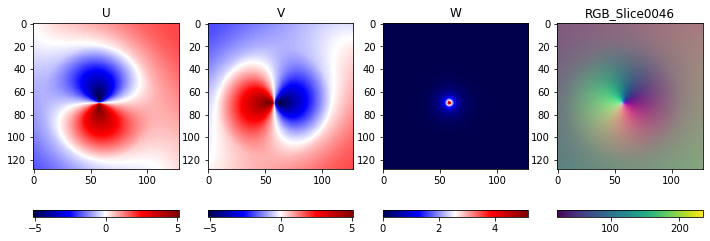

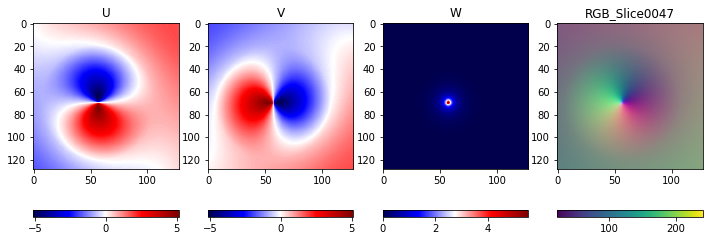

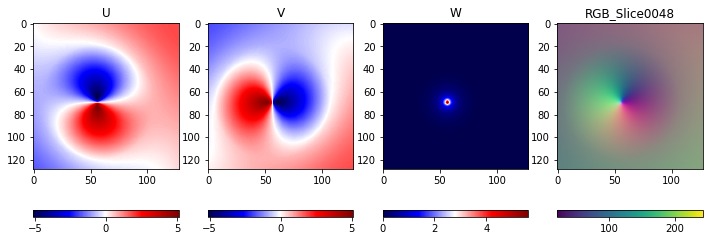

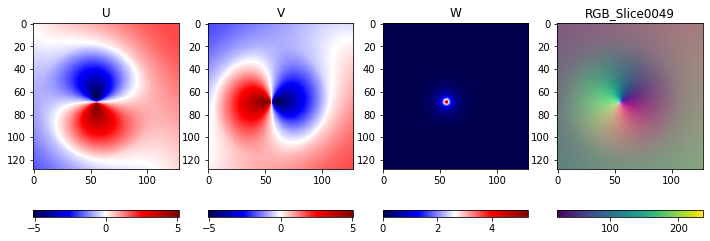

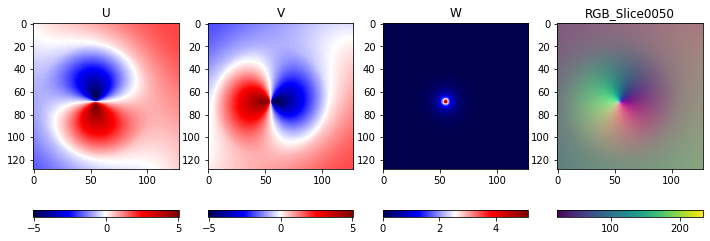

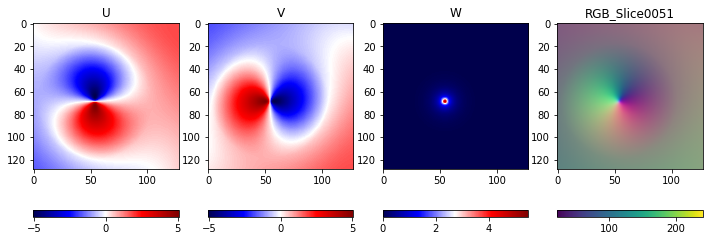

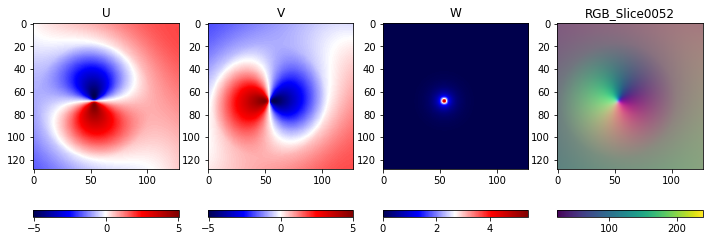

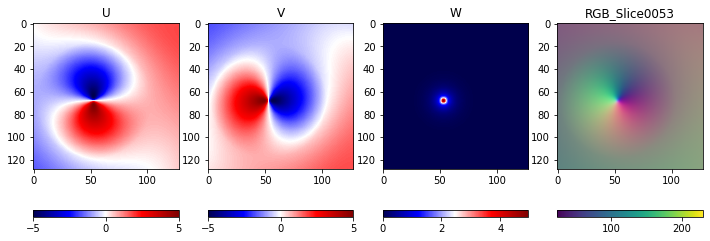

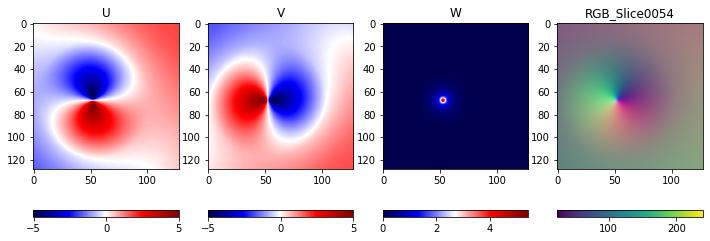

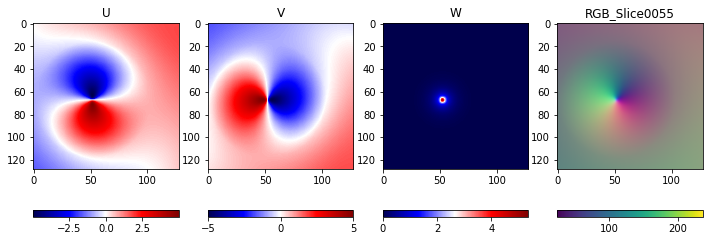

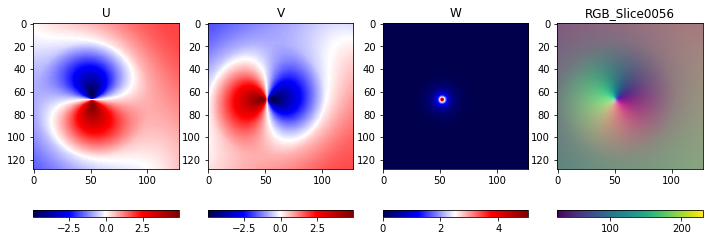

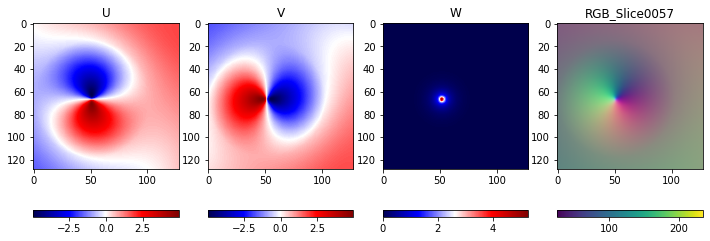

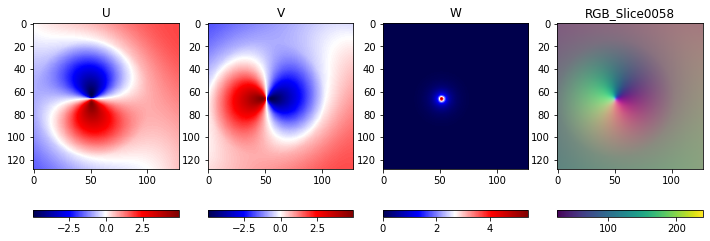

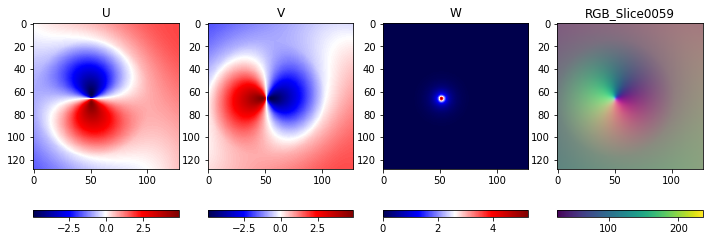

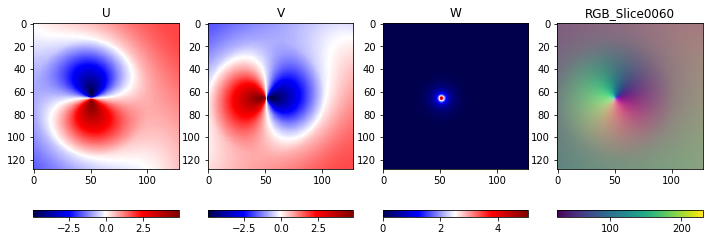

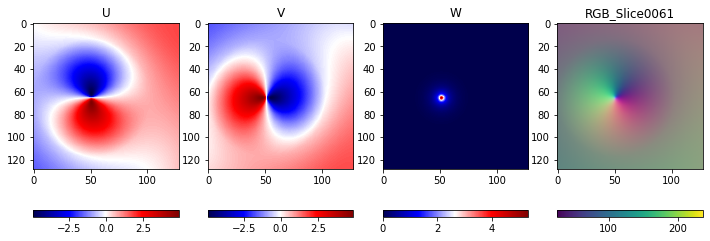

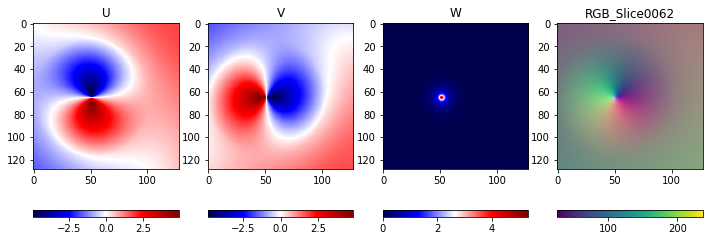

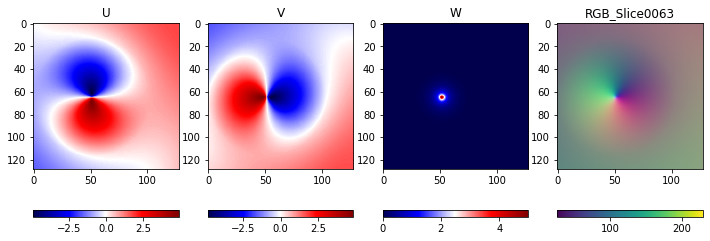

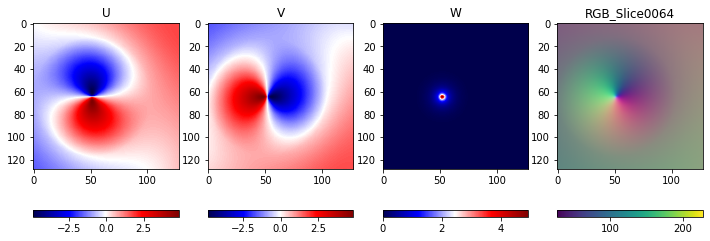

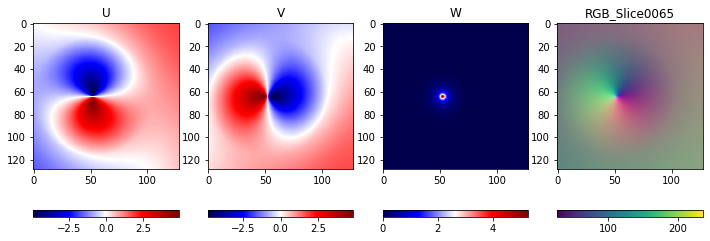

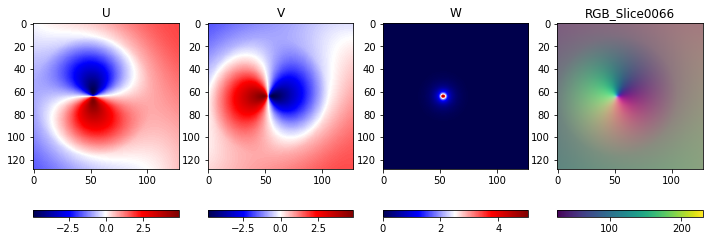

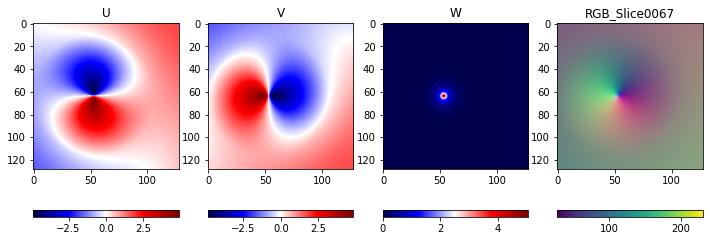

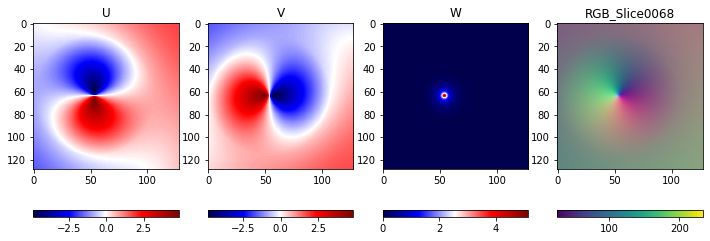

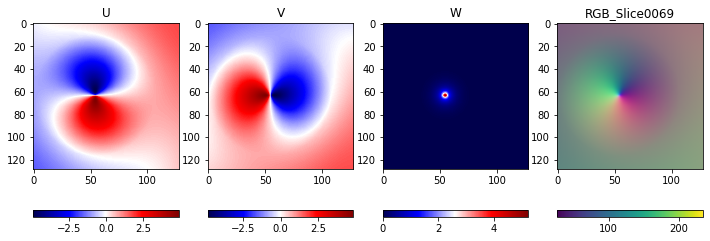

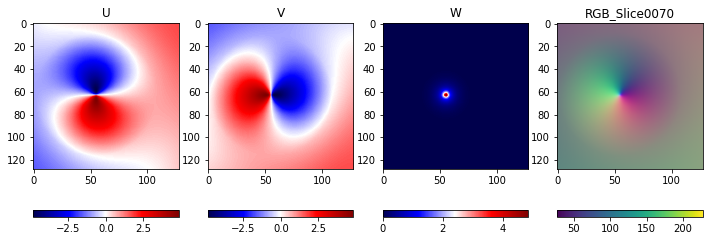

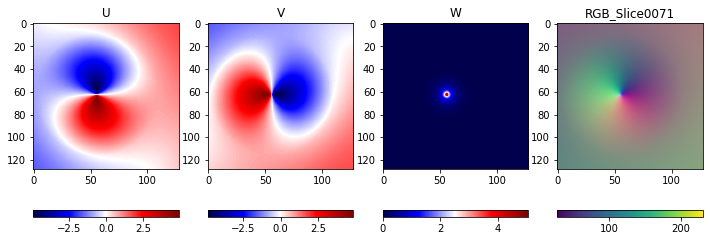

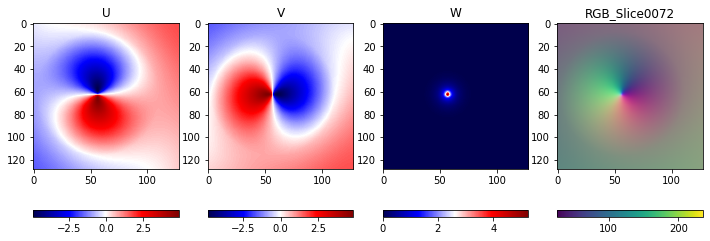

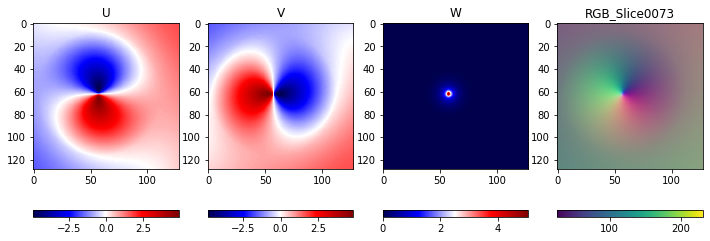

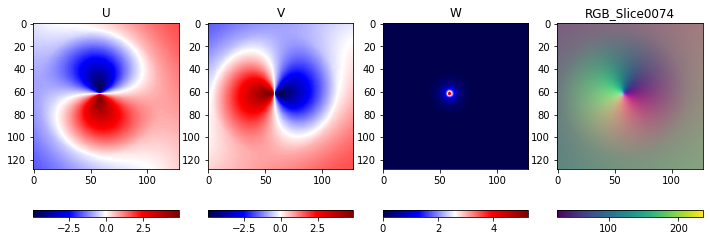

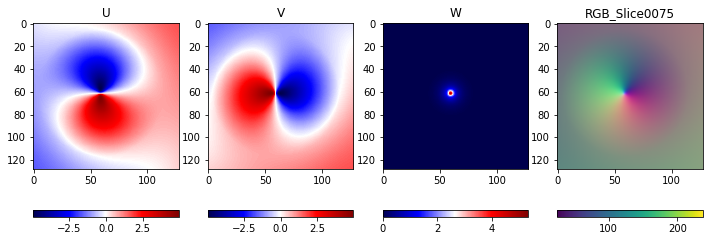

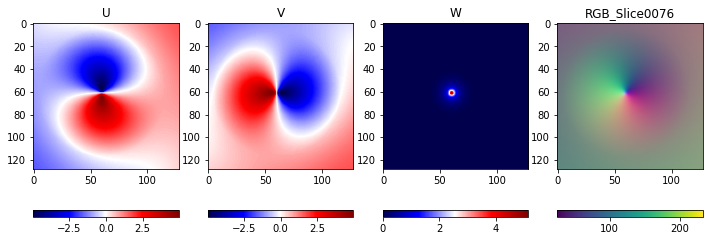

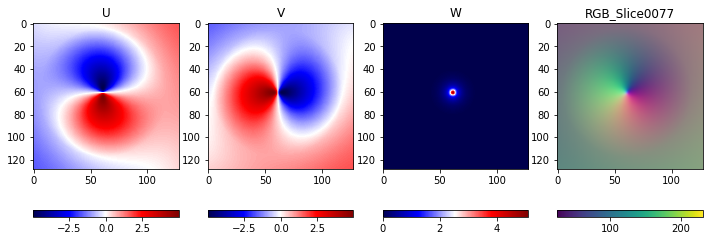

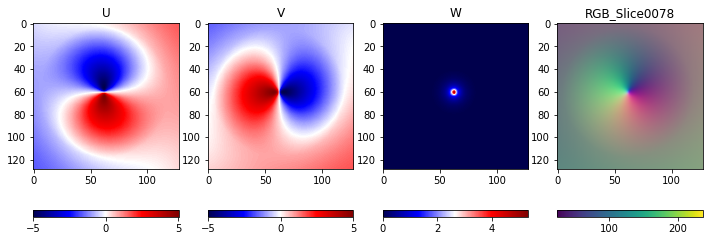

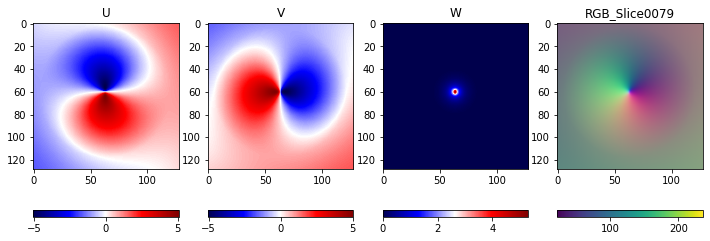

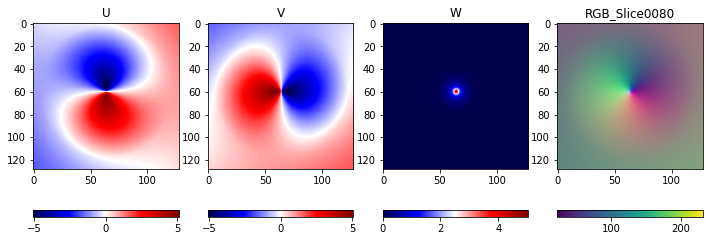

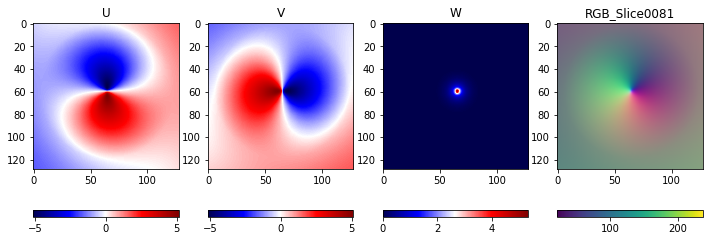

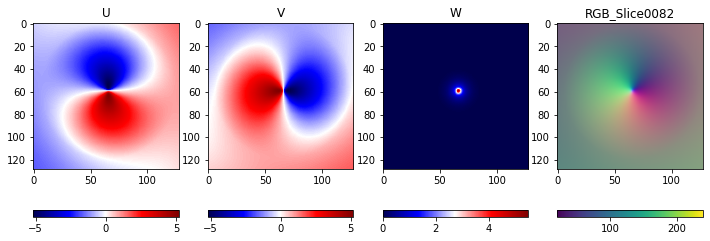

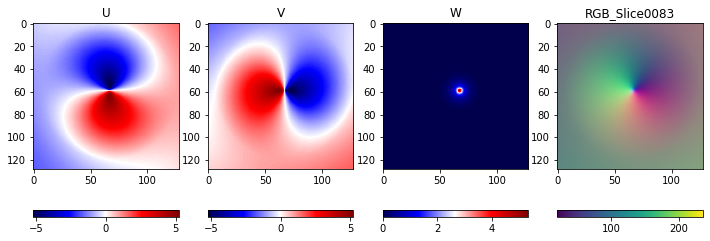

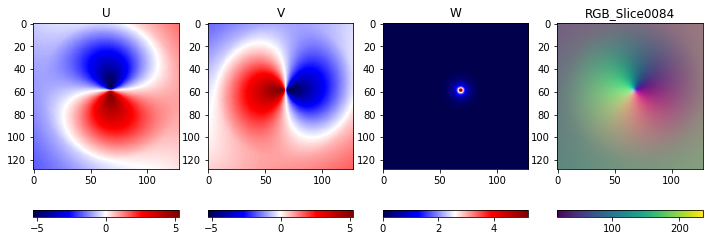

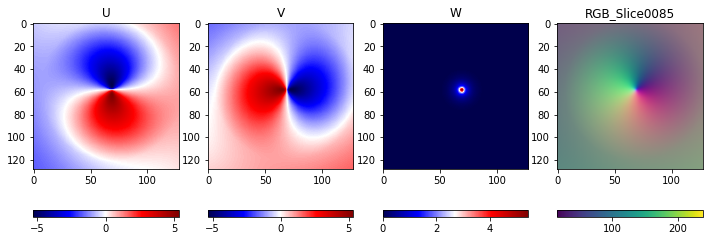

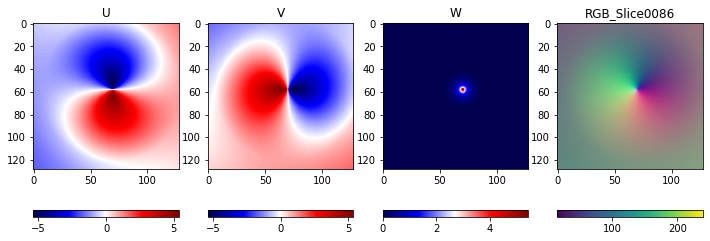

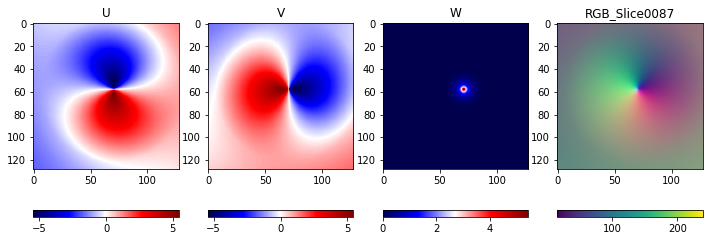

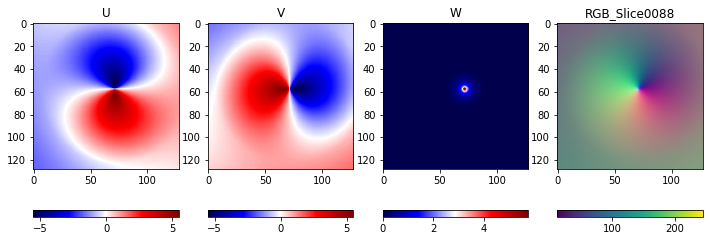

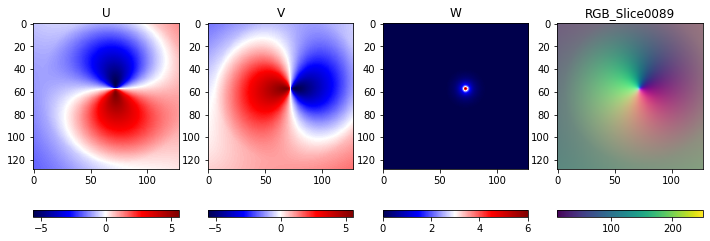

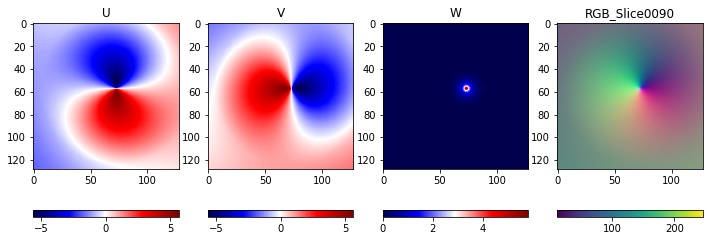

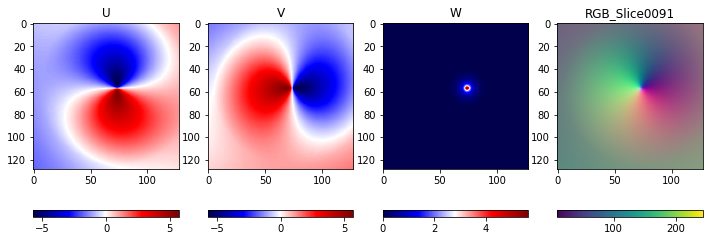

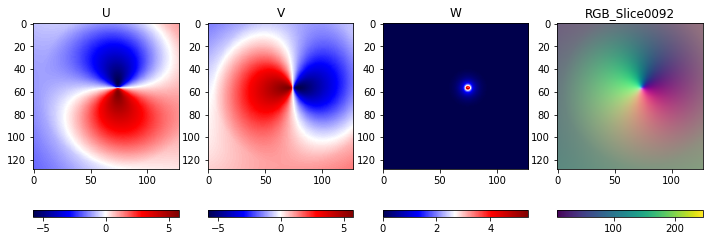

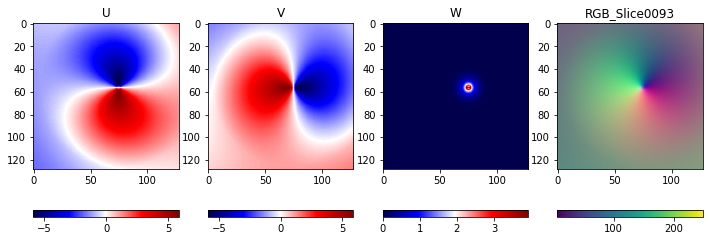

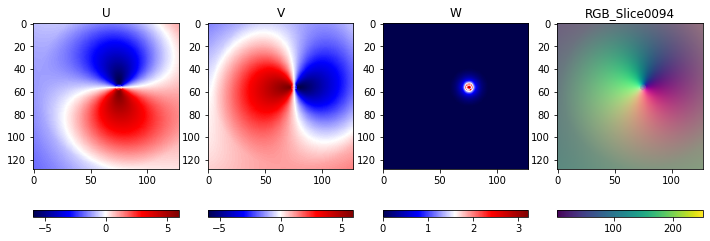

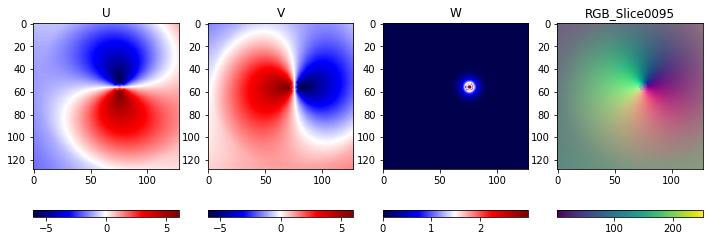

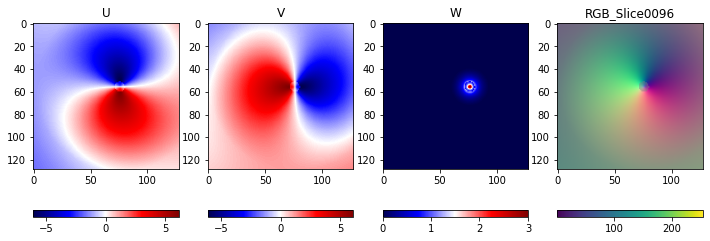

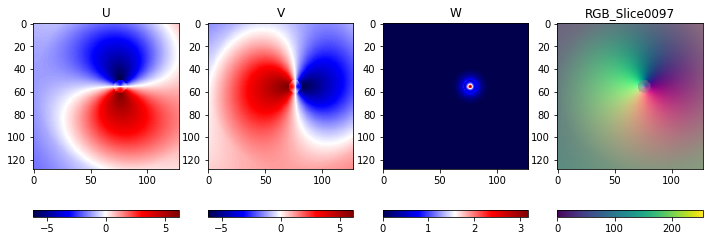

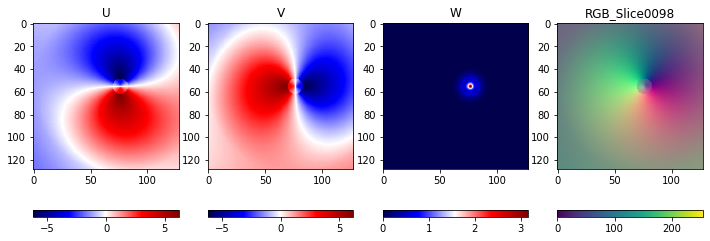

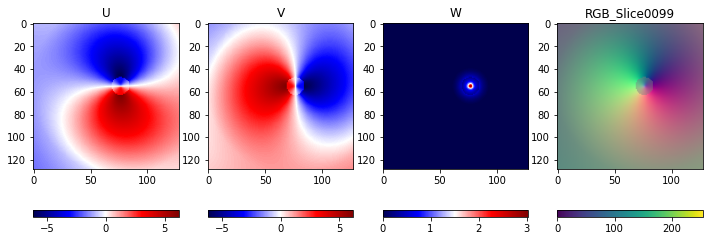

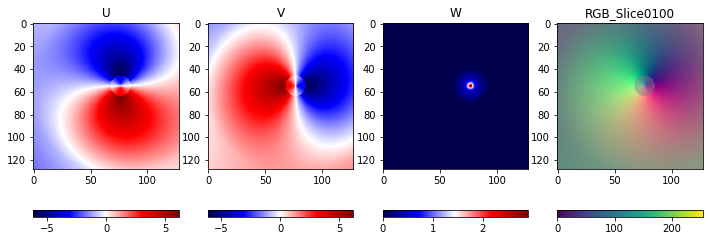

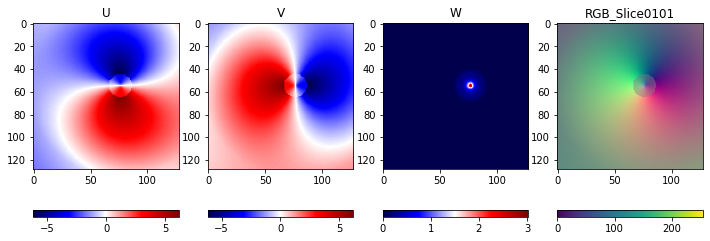

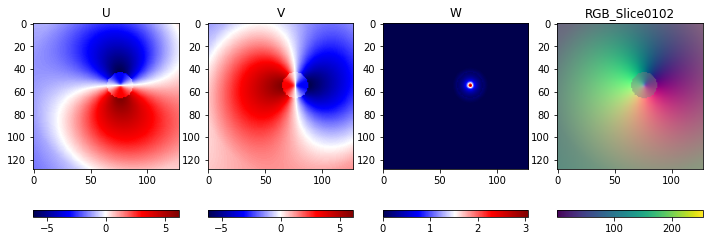

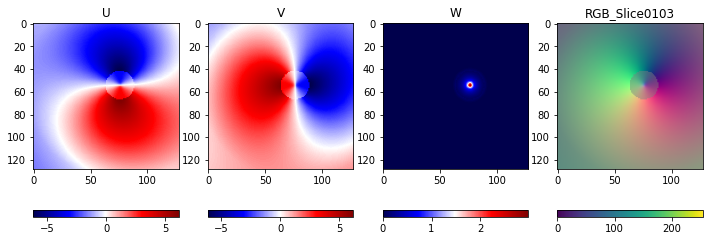

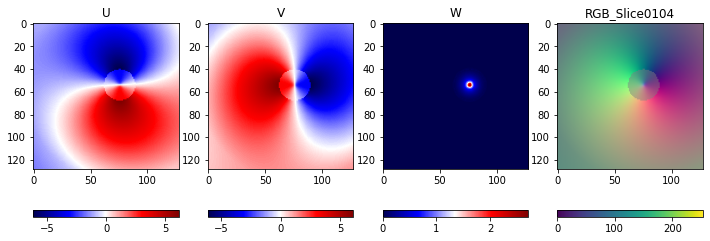

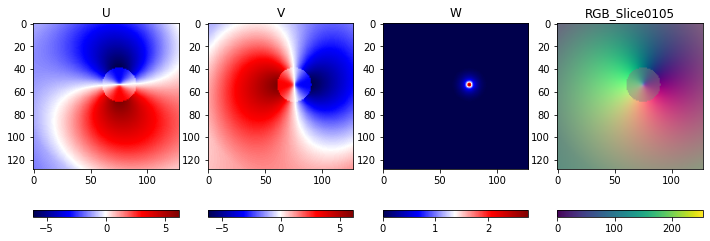

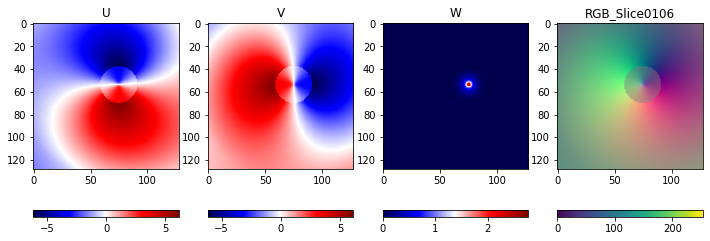

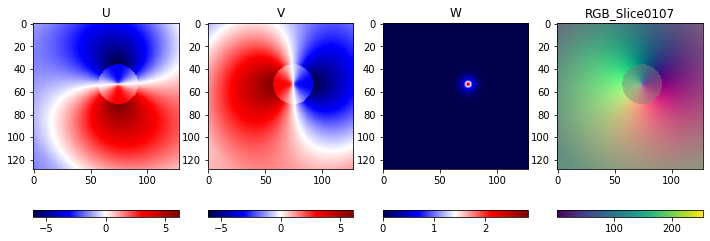

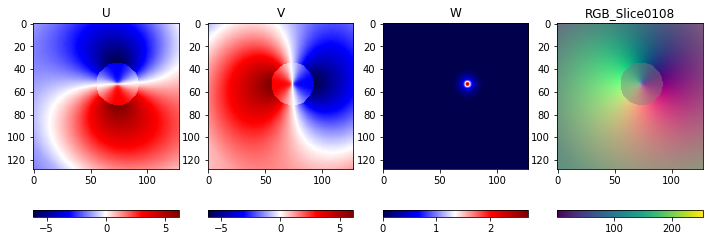

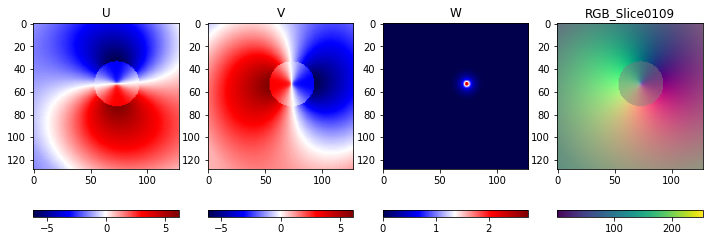

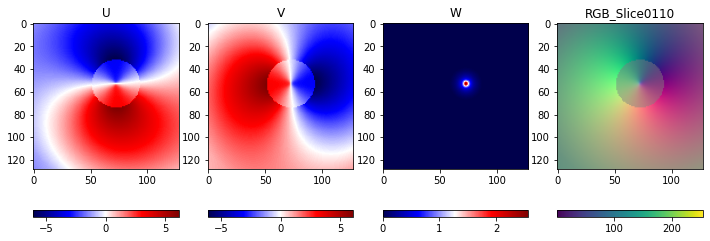

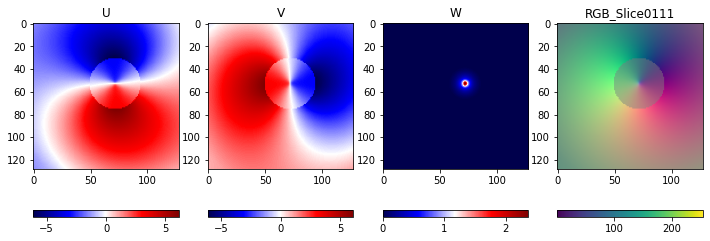

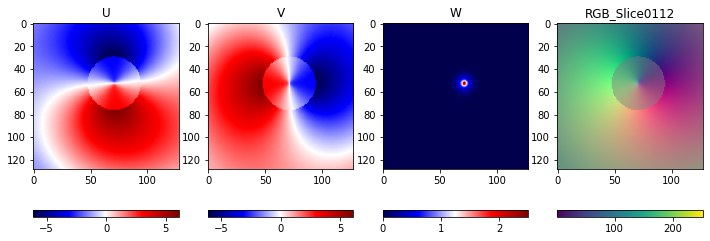

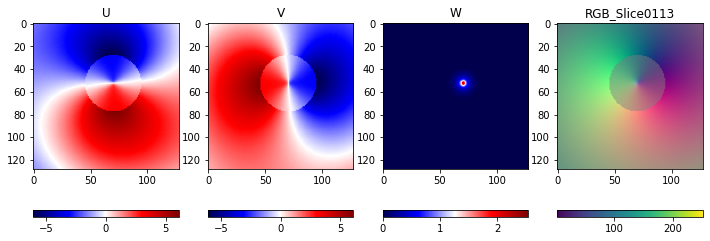

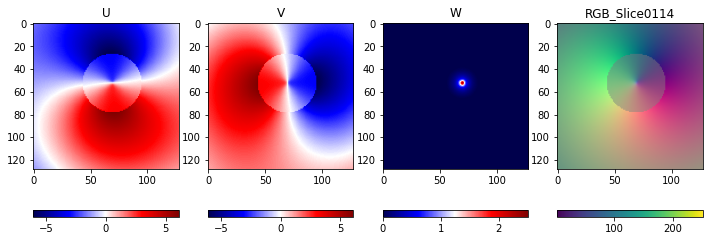

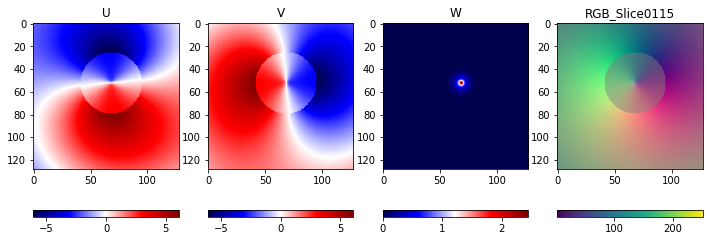

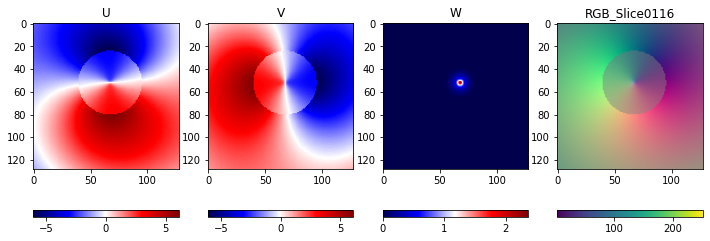

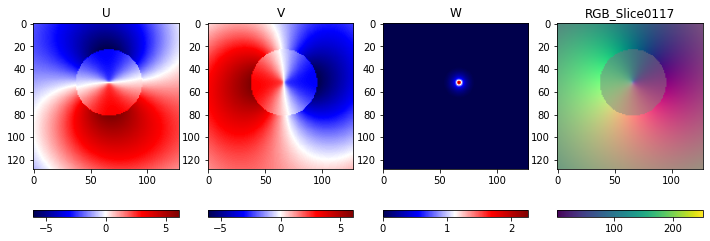

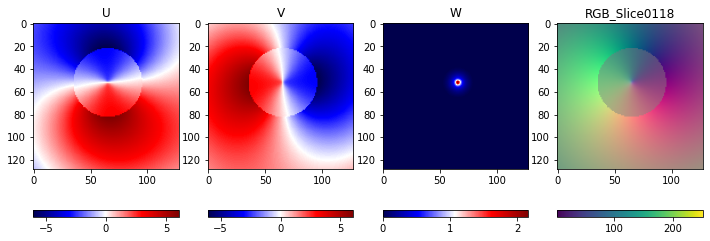

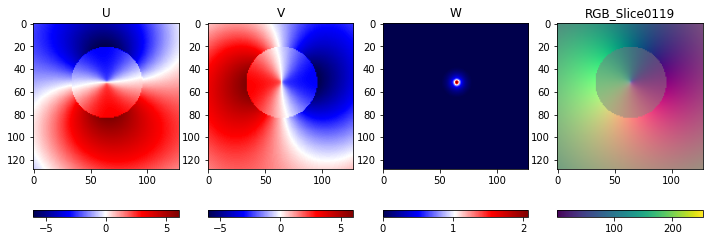

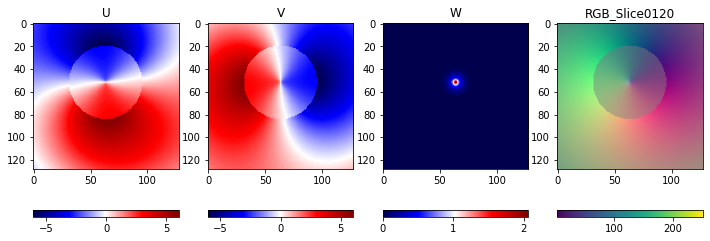

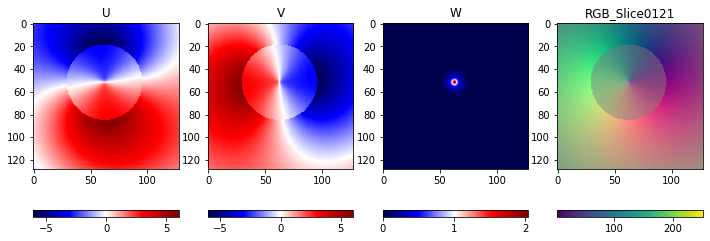

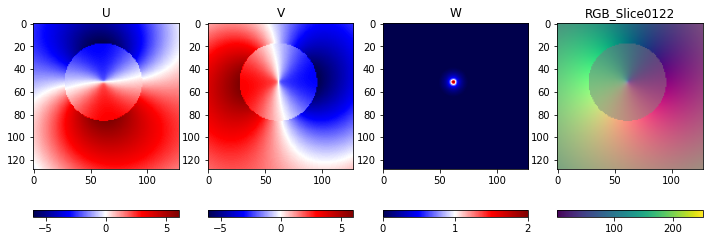

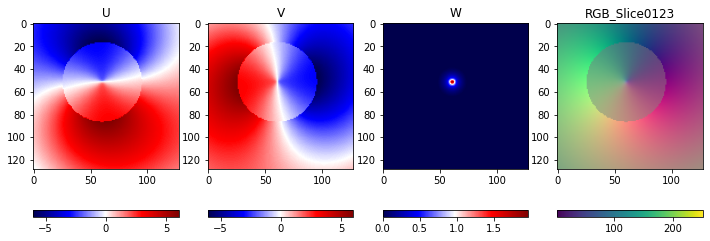

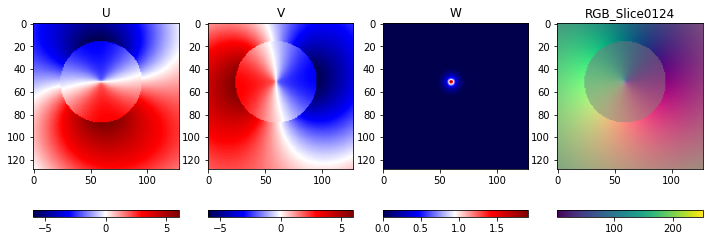

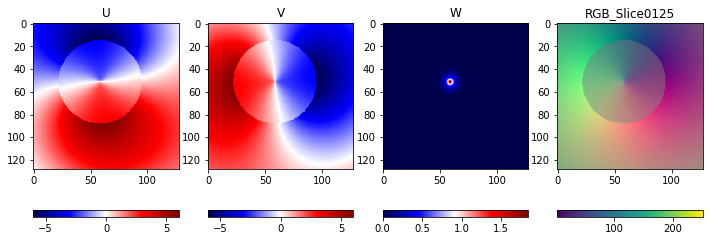

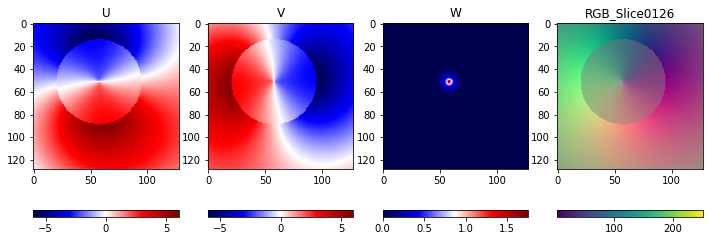

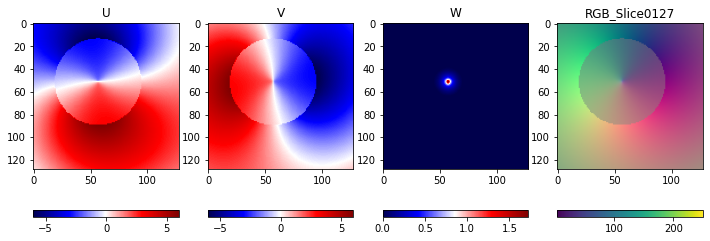

In [16]:
(no_slices,_,_,_) = uvw_norm.shape
for i in range(no_slices):
    U = uvw[i,:,:,0]
    V = uvw[i,:,:,1]
    W = uvw[i,:,:,2]

    fig = plt.figure(figsize=(12,5))
    a = fig.add_subplot(1,4,1)
    plt.imshow(U, cmap='seismic')
    a.set_title('U')
    plt.colorbar(orientation='horizontal')

    a = fig.add_subplot(1,4,2)
    plt.imshow(V, cmap='seismic')
    a.set_title('V')
    plt.colorbar(orientation='horizontal')

    a = fig.add_subplot(1,4,3)
    plt.imshow(W, cmap='seismic')
    a.set_title('W')
    plt.colorbar(orientation='horizontal')
    
    # Actually not needed here......  Will be for create 3D image 
    R = uvw_norm[i,:,:,0]
    G = uvw_norm[i,:,:,1]
    B = uvw_norm[i,:,:,2]
    RGB = (256**2 * R) + (256 * G) + B
    
    a = fig.add_subplot(1,4,4)
    plt.imshow(uvw_norm[i,:,:,:])
    rgb_title = 'RGB_Slice{:04d}'.format(i)
    a.set_title(rgb_title)
    plt.colorbar(orientation='horizontal')

    plt.savefig('images/' + rgb_title)


## Combine individual slices into animation
- Right now this is an animated GIF, but in the future MP4s could take advantage of data transfer schemes found in SOS Explorer
<img align="center" src="tornado-volume-slices.gif">

In [17]:
import glob
import imageio
from PIL import Image

anim_file = 'images/RGB_slices.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/RGB_slice*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info >= (6,2,0,''):
  display.Image(filename=anim_file)

NameError: name 'filename' is not defined

## Write out Normalized Vector Data to a File
- This information is what gets used in Unity for the GPU visualization
- See [server subdirectory](server/) in project

In [23]:
file_name = 'tornado3d.uvw'
file_path = 'server/data/' + file_name

with open(file_path, "wb") as f:
    shape_bytes = np.array(uvw.shape)[:3].astype(np.uint8).tobytes()
    f.write(shape_bytes)
    
    uvw_bytes = uvw_norm.astype(np.int8).flatten().tobytes()
    f.write(uvw_bytes)
    
print('SENT: uvw type=', type(uvw_norm), type(uvw_norm[0,0,0,0]), 'shape=', uvw_norm.shape, ' # cells=', np.prod(uvw_norm.shape), 'sum=', uvw_norm.sum())

SENT: uvw type= <class 'numpy.ndarray'> <class 'numpy.int32'> shape= (128, 128, 128, 3)  # cells= 6291456 sum= 804248128


In [17]:
# test reloading file to make sure values match

with open(file_path, "rb") as f:
    b = f.read(3)
    shape = tuple([b[0], b[1], b[2], 3])
    print(shape)
    uvw2 = np.zeros(shape).astype(np.uint8)
    
    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                for l in range(3):
                    uvw2[i, j, k, l] = int.from_bytes(f.read(1), byteorder='big')
                    if uvw2[i, j, k, l] != uvw_norm[i, j, k, l]:
                        print(uvw2[i, j, k, l], uvw[i, j, k, l])
    
print('RECEIVED: uvw type=', type(uvw2), type(uvw2[0,0,0,0]), 'shape=', uvw2.shape, ' # cells=', np.prod(uvw2.shape), 'sum=', uvw2.sum())

(128, 128, 128, 3)
RECEIVED: uvw type= <class 'numpy.ndarray'> <class 'numpy.uint8'> shape= (128, 128, 128, 3)  # cells= 6291456 sum= 804248128


## Flask Microservice
- Located in the [server folder](server/)
- Start the python script from command line
- Open [response tester](server/TensorClientTester.ipynb) to see the service in action

<img align="right" width="400" height="200" src="unity-vfx.png">

# VFX Shader Graphs
- Done in Unity
- Work checked into the Github project but not currently accessible via notebooks
- Install "unity package" in cloned copy of [Unity's VFX Samples](https://github.com/Unity-Technologies/VisualEffectGraph-Samples)

# Future Work
- Improve Flask microservice to generate 3D textures from latest model runs
- Leverage data useful to GSL
  - For example [NOAA HRRR Model on AWS](https://registry.opendata.aws/noaa-hrrr-pds/)
- Build interactive controls to modify visualizations in real-time